## To do
Think about adding a sustainable groundwater flow parameter, as really struggling with baseflow during long, dry summers.

Try with old observed discharge data - how does NS compare to INCA?

Think about how to organise/tidy up, turn into functions, etc.

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, numpy as np, pandas as pd
sn.set_context('notebook')

In [79]:
# Download Tarland data into dataframes
metdata_fpath = r'M:\Working\NewModel\ModelInputs\Tar_AvMetData_1981-2010.csv'
obsdata_fpath = r'M:\Working\NewModel\ModelInputs\Coull_9amDailyMeanQ_newRating.csv'

met_df = pd.read_csv(metdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
obs_df = pd.read_csv(obsdata_fpath, parse_dates=True, dayfirst=True, index_col=0)

# Truncate the met and observed data to the desired period
st_dt = '2000-01-01'  # Start date
end_dt = '2010-12-31' # End date
period = [st_dt, end_dt]
met_df = met_df.truncate(before=period[0], after=period[1])
obs_df = obs_df.truncate(before=period[0], after=period[1])

# Convert cumecs to mm per day
cat_area = 51.7E6 # Catchment area in m2
obs_df['Runoff_mm'] = obs_df['Q_Cumecs']*60*60*24*1000/cat_area
del obs_df['Q_Cumecs']

# Linear interpolation of any missing values
met_df.interpolate(method='linear', inplace=True)

print met_df.head()
print obs_df.head()

            T_air   PET  Pptn
Date                         
2000-01-01   4.34  0.72  0.10
2000-01-02   6.04  0.72  1.00
2000-01-03   4.49  0.72  1.10
2000-01-04   1.62  0.72  1.38
2000-01-05   4.07  0.72  3.62
            Runoff_mm
Date                 
2000-01-01   1.297504
2000-01-02   1.304857
2000-01-03   1.220296
2000-01-04   1.155955
2000-01-05   1.167152


In [80]:
# SNOW ACCUMULATION AND MELT

# Source for priors for DDF: http://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=17753.wba
# To Do:
# (1) Add options for how temperature is assumed to vary through the day. At the moment, assume average
# temperature throughout the day. In future, could look at triangular or sinuosoidal variations throughout
# the day, to get a more accurate portrayal of the degree-days above the threshold.
# Also assumes no melting below 0 deg C.

# (2) Consider setting ET to 0 when D_snow > 0.

def hydrol_inputs(D_snow_0, f_DDSM, met_df):
    """Function to calculate snow accumulation and melt.
    Calculates total hydrological input to soil box as precipitation as precipitation as rain + snowmelt
    
    D_snow_0: Initial snow depth (mm)
    f_DDSM: Degree-day factor for snow melt (mm/degree-day deg C)
    met_df: Dataframe of met data with cols T_air, PET, Pptn
    
    Returns met_df with additional columns [P_snow, P_rain, P_melt, D_snow_start
    D_snow_end, P]
    
    Of these, P is the hydrological input to the soil store
    """

    # Calculate precipitation falling as snow and add to met_df
    met_df.loc[:,'P_snow'] = met_df['Pptn'].ix[met_df['T_air']<0]
    met_df['P_snow'].fillna(0, inplace=True)

    # Calculate precipitation falling as rain and add to met_df
    met_df['P_rain'] = met_df['Pptn'] - met_df['P_snow']

    # Calculate daily snow melt, if unlimited snow pack depth to melt (mm/day)
    met_df['P_melt'] = f_DDSM*(met_df['T_air']-0)
    met_df['P_melt'][met_df['P_melt']<0]=0  # Set negative values to 0

    # Calculate snow pack depth
    met_df['D_snow_start'] = np.nan
    met_df['D_snow_end'] = np.nan

    # First time-step manually, to take initial condition into account
    met_df.ix[0,'D_snow_start'] = D_snow_0 #Assign start snow depth to first row
    met_df.ix[0,'P_melt'] = np.minimum(met_df.ix[0,'P_melt'],met_df.ix[0,'D_snow_start'])
    met_df.ix[0,'D_snow_end'] = met_df.ix[0,'D_snow_start']+met_df.ix[0,'P_snow']-met_df.ix[0,'P_melt']

    # Calculte for subsequent days
    for idx in range (1,len(met_df)):
        met_df.ix[idx,'D_snow_start'] = met_df.ix[idx-1,'D_snow_end']
        met_df.ix[idx,'P_melt'] = np.minimum(met_df.ix[idx,'P_melt'],met_df.ix[idx,'D_snow_start'])
        met_df.ix[idx,'D_snow_end'] = met_df.ix[idx,'D_snow_start']+met_df.ix[idx,'P_snow']-met_df.ix[idx,'P_melt']

    # Hydrological input to soil box
    met_df.loc[:,'P'] = met_df['P_rain'] + met_df['P_melt']
    
    return met_df

# Parameters
D_snow_0 = 0.  # Initial snow depth (mm)
f_DDSM = 2.74 # Degree-day factor for snow melt (mm/degree-day deg C)

met_df = hydrol_inputs(D_snow_0, f_DDSM, met_df)
print met_df.head()


            T_air   PET  Pptn  P_snow  P_rain  P_melt  D_snow_start  \
Date                                                                  
2000-01-01   4.34  0.72  0.10       0    0.10       0             0   
2000-01-02   6.04  0.72  1.00       0    1.00       0             0   
2000-01-03   4.49  0.72  1.10       0    1.10       0             0   
2000-01-04   1.62  0.72  1.38       0    1.38       0             0   
2000-01-05   4.07  0.72  3.62       0    3.62       0             0   

            D_snow_end     P  
Date                          
2000-01-01           0  0.10  
2000-01-02           0  1.00  
2000-01-03           0  1.10  
2000-01-04           0  1.38  
2000-01-05           0  3.62  


In [81]:
# DEFINE ODE SYSTEM AS A FUNCTION

from scipy.integrate import odeint

def f(y, t, params):
    """ Define ODE system.
            y is list [Vs, Qs, Qg, Ds, Dg]
            t is an array of time points of interest
            params is a tuple (P, E, f_IExcess, alpha, beta, T_s, T_g, fc)
    """
    # Unpack incremental values for S and G
    Vs_i = y[0]
    Qs_i = y[1]
    Qg_i = y[2]
    
    # Unpack params
    P, E, f_IExcess, alpha, beta, T_s, T_g, fc = params

    # Model equations (see section 2.2)
    ##dQq_dt = (f_IExcess*P - Qq_i)/T_q
    dQs_dV = (((Vs_i - fc)*np.exp(fc - Vs_i))/(T_s*((np.exp(fc-Vs_i) + 1)**2))) + (1/(T_s*(np.exp(fc-Vs_i) + 1)))
    dVs_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*Vs_i)) - Qs_i
    dQs_dt = dQs_dV*dVs_dt
    dQg_dt = (beta*Qs_i - Qg_i)/T_g
    dDs_dt = (1 - beta)*Qs_i
    dDg_dt = Qg_i
    
    # Add results of equations to an array
    res = np.array([dVs_dt, dQs_dt, dQg_dt, dDs_dt, dDg_dt])
    
    return res

                    Vs        Qs        Qg          Ds          Dg
298.798799  332.039182  4.203918  2.258134  380.289641  344.621021
299.099099  332.039182  4.203918  2.258927  380.794617  345.299258
299.399399  332.039182  4.203918  2.259717  381.299592  345.977733
299.699700  332.039182  4.203918  2.260504  381.804567  346.656445
300.000000  332.039182  4.203918  2.261289  382.309542  347.335393


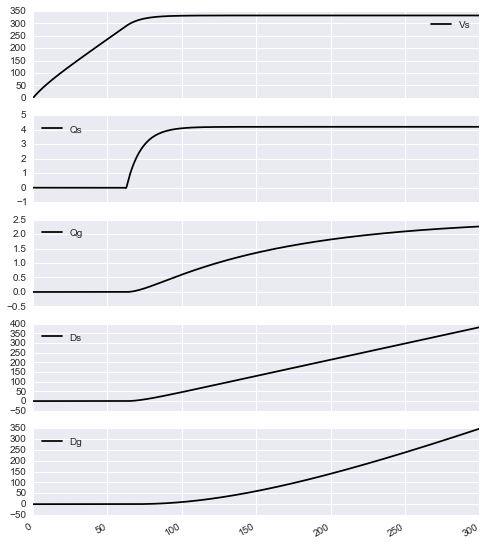

In [82]:
# SOLVE ODES WITH CONSTANT INPUT FLUXES OVER ONE TIME STEP

# Example model parameters
f_IExcess = 0.1 # Proportion of incoming rainfall that contributes to infiltration excess
alpha = 0.75    # PET correction factor (dimensionless)
beta = 0.6      # BFI (dimensionless)
T_s = 10.       # Soil residence time (days)
T_g = 100.      # Groundwater residence time (days)
fc = 290.       # Field capacity (mm)
step_len = 300  # Time step length (days)

# Example initial conditions
P = 8.         # Precipitation (mm/day)
E = 4.         # PET (mm/day)
Vs0 = 0.       # Initial soil volume (mm)
Vg0 = 0.       # Initial groundwater volume (mm)

# Calculate initial flows from initial volumes and time constants
Qs0 = (Vs0 - fc)/(T_s*(1 + np.exp(fc - Vs0)))
Qg0 = Vg0/T_g

# Array of time points at which to evaluate ODEs
ti = np.linspace(0, step_len, 1000)

# Vector of initial conditions
y0 = [Vs0, Qs0, Qg0, 0., 0.]

# Model parameters
params=[P, E, f_IExcess, alpha, beta, T_s, T_g, fc]

# Solve
y = odeint(f, y0, ti, args=(params,))

# Build df from output
df = pd.DataFrame(data=y,
                  columns=['Vs', 'Qs', 'Qg', 'Ds', 'Dg'],
                  index=ti)
df.plot(subplots=True, figsize=(8, 10))
print df.tail()

In [83]:
def simple_hydro_model(met_df, ics, mod_params, period, step_len=1):
    """ The hydrological model
    
            met_df         Dataframe containing columns 'P' and 'PET', with datetime index
            ics            Vector of initial conditions [Vs0, Vg0]
            mod_params     Vector of params [f_IExcess, alpha, beta, T_s, T_g, fc]
            period         Vector of [start, end] dates [yyyy-mm-dd, yyyy-mm-dd]
            step_len       Length of each step in the input dataset (days)
        
        Returns a dataframe with column headings
        
            [Vs, Qs, Qg, Ds, Dg, Sim_Runoff, Obs_Runoff]
    """
    # Truncate the met data to the desired period
    input_df = met_df.truncate(before=period[0], after=period[1])

    # Unpack initial conditions
    Vs0, Vg0 = ics
    
    # Unpack model parameters
    f_IExcess, alpha, beta, T_s, T_g, fc = mod_params
    
    # Time points to evaluate ODEs at. We're only interested in the start and the end of each step
    ti = [0, step_len]

    # Lists to store output
    output_ODEs = []
    output_rest = []

    # Loop over met data
    for idx in range(len(input_df)):
        # Get P and E for this day
        P = input_df.ix[idx, 'P']
        E = input_df.ix[idx, 'PET']
        
        # Calculate infiltration excess and add to results
        Qq = np.array(f_IExcess*P)
        output_rest.append(Qq)

        # Calculate Qs0 and Qg0 from Vs0 and Vg0
        Qs0 = (Vs0 - fc)/(T_s*(1 + np.exp(fc - Vs0)))
        Qg0 = Vg0/T_g 

        # Vector of initial conditions
        y0 = [Vs0, Qs0, Qg0, 0., 0.]

        # Model parameters
        params=[P, E, f_IExcess, alpha, beta, T_s, T_g, fc]

        # Solve
        y = odeint(f, y0, ti, args=(params,))

        # Extract values for end of step
        res = y[1]
        
        # Append quick flow infiltration excess values to results
        #np.hstack((res,Qq))

        # Numerical errors may result in very tiny values <0
        # set these back to 0
        res[res<0] = 0
        output_ODEs.append(res)

        # Update initial conditions for next step
        Vs0 = res[0]
        Vg0 = res[2]*T_g

    # Build a dataframe of ODE results
    df1 = pd.DataFrame(data=np.vstack(output_ODEs),
                      columns=['Vs', 'S', 'G', 'Ds', 'Dg'],
                      index=input_df.index)
    
    # Dataframe of non ODE results
    df2 = pd.DataFrame(data=np.vstack(output_rest), columns=['Qq'],
                     index=input_df.index)
    
    # Concatenate results dataframes
    df = pd.concat([df1,df2], axis=1)
    
    # Estimate runoff as Ds + Dg
    df['Sim_Runoff_mm_IE'] = df['Ds'] + df['Dg'] + df['Qq']
    df['Sim_Runoff_mm'] = df['Ds'] + df['Dg']

    # Add observed runoff to df
    df['Obs_Runoff_mm'] = obs_df['Runoff_mm']

    return df

In [84]:
# RUN MODEL FOR A COUPLE OF YEARS

# Model setup

# Snow melt parameters
D_snow_0 = 0.  # Initial snow depth (mm)
f_DDSM = 2.74 # Degree-day factor for snow melt (mm/degree-day deg C)

# Model parameters
inc_snowmelt = 1   # Include snow melt and accumulation module? Boolean 0 or 1
f_IExcess = 0.02       # Proportion of incoming rainfall that contributes to infiltration excess
alpha = 0.75            # PET correction factor (dimensionless)
beta = 0.6            # BFI (dimensionless)
T_s = 3.             # Soil residence time (days)
T_g = 60.            # Groundwater residence time (days)
fc = 400              # Field capacity (mm) #SSKIB: 290
st_dt = '2000-01-01'  # Start date
end_dt = '2010-12-31' # End date

# Initial conditions
Vs0 = fc       # Initial soil volume (mm)
Vg0 = 50.       # Initial groundwater volume (mm)

# Run model
if inc_snowmelt == 1:
    met_df = hydrol_inputs(D_snow_0, f_DDSM, met_df)
else:
    met_df.rename(columns={'Pptn':'P'}, inplace=True)

df = simple_hydro_model(met_df=met_df,
                        ics=[Vs0, Vg0],
                        mod_params=[f_IExcess, alpha, beta, T_s, T_g, fc],
                        period=[st_dt, end_dt])

# Discard burn-in
# df = df.truncate(before='2004-01-01')

df['D_snow'] = met_df['D_snow_end'] #Add snow depth to results dataframe

print df.tail()


                    Vs         S         G        Ds        Dg        Qq  \
Date                                                                       
2010-12-27  400.626202  0.136017  1.431931  0.062500  1.443181  0.000000   
2010-12-28  406.494480  2.161559  1.420246  0.482145  1.424359  0.144360   
2010-12-29  409.244295  3.081134  1.423039  1.058975  1.420882  0.110148   
2010-12-30  410.841112  3.613633  1.432869  1.344872  1.427524  0.101204   
2010-12-31  416.181325  5.393774  1.454363  1.821233  1.442165  0.201904   

            Sim_Runoff_mm_IE  Sim_Runoff_mm  Obs_Runoff_mm   D_snow  
Date                                                                 
2010-12-27          1.505681       1.505681       2.011766  43.0492  
2010-12-28          2.050864       1.906504       2.659181  38.3912  
2010-12-29          2.590005       2.479857       2.516797  32.8838  
2010-12-30          2.873600       2.772396       2.308902  28.1436  
2010-12-31          3.465302       3.263398    

NSE_IE: 0.616843653531
NSE, no IE: 0.621846284443
NSE on logs, inc. IE: 0.455790310867
NSE on logs, no IE: 0.377404259211


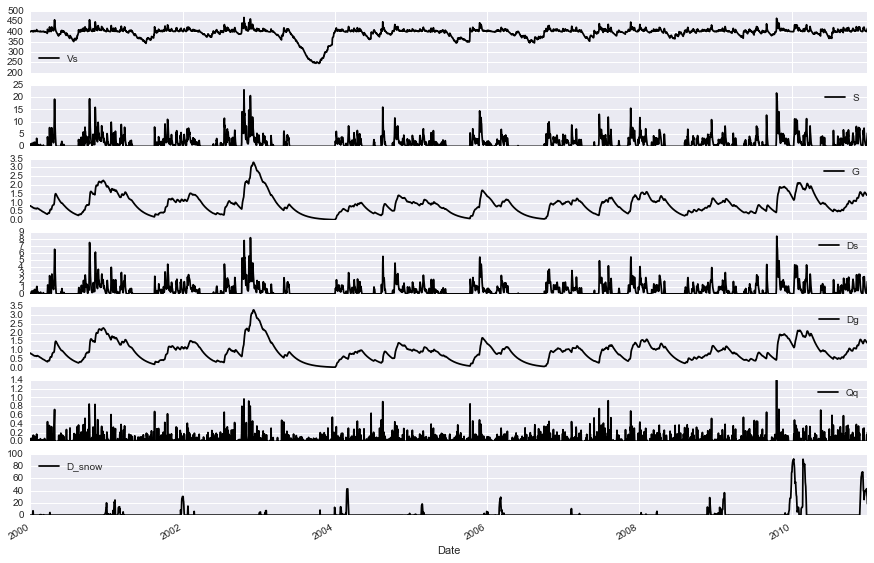

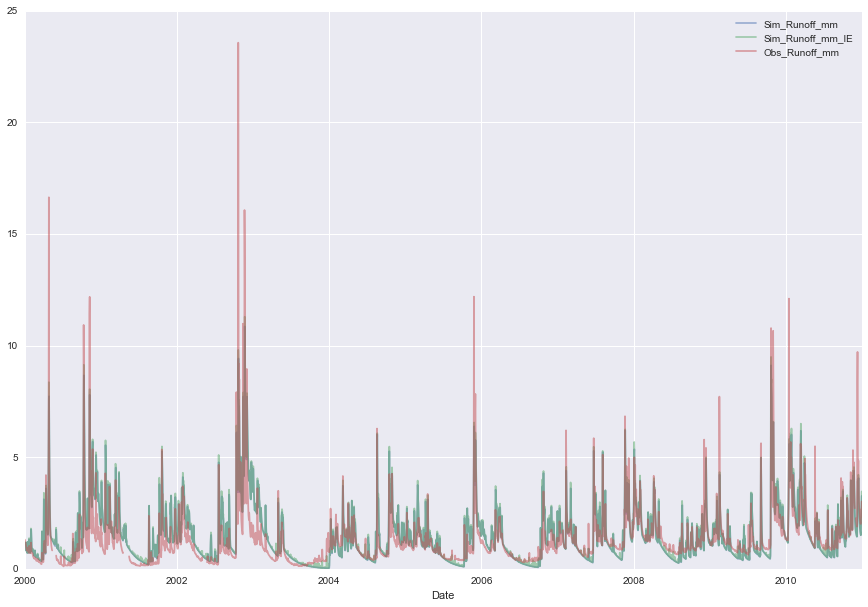

In [85]:
# Plot the simulated results
df[['Vs', 'S', 'G', 'Ds', 'Dg', 'Qq','D_snow']].plot(subplots=True,
                                      figsize=(15, 10))

df[['Sim_Runoff_mm', 'Sim_Runoff_mm_IE', 'Obs_Runoff_mm']].plot(alpha=0.5,
                                            figsize=(15, 10))

# Print some stats
obs = df['Obs_Runoff_mm']
sim_IE = df['Sim_Runoff_mm_IE']
sim = df['Sim_Runoff_mm']

log_obs = np.log(obs)
log_sim_IE = np.log(sim_IE)
log_sim = np.log(sim)

NSE_IE = 1 - (np.sum((obs-sim_IE)**2)/np.sum((obs-np.mean(obs))**2))
NSE = 1 - (np.sum((obs-sim)**2)/np.sum((obs-np.mean(obs))**2))

log_NSE_IE = 1 - (np.sum((log_obs-log_sim_IE)**2)/np.sum((log_obs-np.mean(log_obs))**2))
log_NSE = 1 - (np.sum((log_obs-log_sim)**2)/np.sum((log_obs-np.mean(log_obs))**2))

print "NSE_IE:", NSE_IE
print "NSE, no IE:", NSE
print "NSE on logs, inc. IE:", log_NSE_IE
print "NSE on logs, no IE:", log_NSE